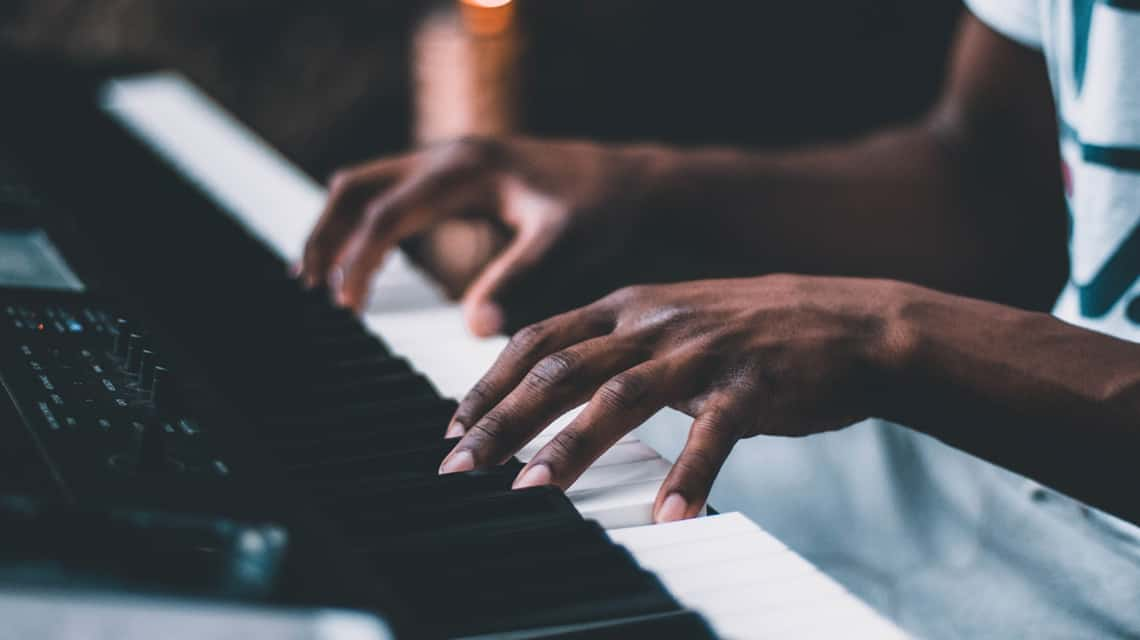

In [2]:
import glob
import pickle
import numpy as np
import os
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib as plt
import pathlib
from music21 import converter, instrument, note, chord, stream

In [ ]:
#Show some midi files
midi_files = os.listdir('./drive/MyDrive/data')
midi_files[:10]

['0fithos.mid',
 '8.mid',
 'BlueStone_LastDungeon.mid',
 'DOS.mid',
 'Cids.mid',
 'AT.mid',
 'Final_Fantasy_Matouyas_Cave_Piano.mid',
 'HighwindTakestotheSkies.mid',
 'Eternal_Harvest.mid',
 'OTD5YA.mid']

#Audio Processing
First step we should do is present full set of unique notes and chords that dataset contains. Let's call it tokens

In [ ]:
midis = list()
for file in glob.glob("./drive/MyDrive/data/*.mid"):
  midi = converter.parse(file)
  midis.append(midi)

midis = np.array(midis)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
#This function convert midi to strig notation

def midi_to_string_notation(midi):
  string_notation = list()
  string_notation.append(' ')
  notes_to_parse = None
  parts = instrument.partitionByInstrument(midi)
  if parts:  # file has instrument parts
    notes_to_parse = parts.parts[0].recurse()
  else:  # file has notes in a flat structure
    notes_to_parse = midi.flat.notes
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      string_notation.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      string_notation.append('.'.join(str(n) for n in element.normalOrder))
  return np.array(string_notation)

In [ ]:
#Example
string_notation = midi_to_string_notation(midis[3])
print(string_notation[:10], '...')
print('Len of the composition:', len(string_notation))

[' ' 'G2' 'G3' '7.0' 'G3' 'B2' 'G3' '7.11' 'G3' 'A2'] ...
Len of the composition: 625


In [ ]:
#Here we convert all midis to their string notation

string_notations = list()

for midi in midis:
  string_notations.append(midi_to_string_notation(midi))

string_notations = np.array(string_notations)

assert len(midis) == len(string_notations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
import matplotlib.pyplot as plt

MAX_LENGTH = max(map(len, string_notations))

def show_statistics(string_notations):
  sum = 0
  for string_notation in string_notations:
    sum = sum + len(string_notation)

  MEAN_LENGTH = sum/len(string_notations)

  print('amount=', len(string_notations))
  print("max length =", MAX_LENGTH)
  print('mean length =', int(MEAN_LENGTH))

  plt.title('Composition length distribution')
  plt.hist(list(map(len, string_notations)),bins=25);

amount= 92
max length = 2211
mean length = 622


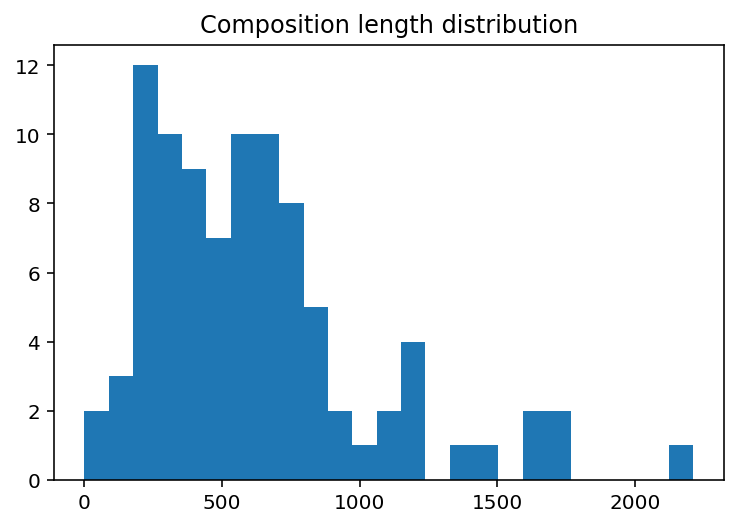

In [ ]:
show_statistics(string_notations)

In [ ]:
filter = []

for string_notation in string_notations:
  if len(string_notation) > 662:
    filter.append(False)
  if len(string_notation) <= 662:
    filter.append(True)
  
string_notations = string_notations[filter]

In [ ]:
index = []

for i in range(string_notations.shape[0]):
  if string_notations[i].shape[0] == 1:
    index.append(i)

string_notations = np.delete(string_notations, index)

amount= 56
max length = 2211
mean length = 387


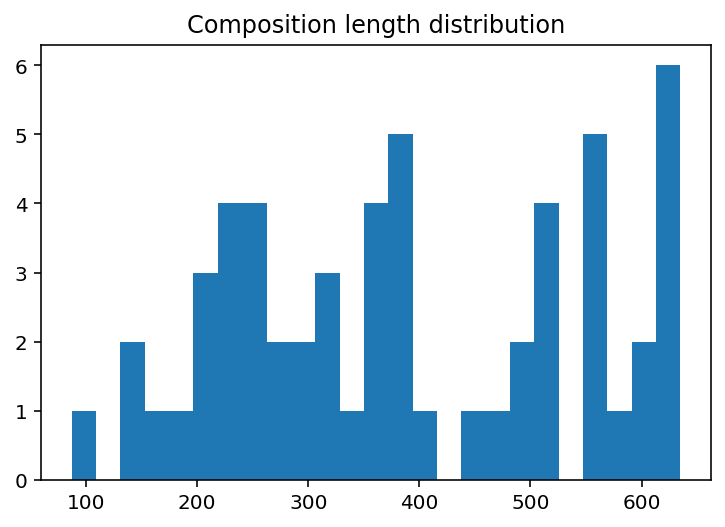

In [ ]:
show_statistics(string_notations)

In [ ]:
tokens = set()
for string_notation in string_notations:
  for elem in string_notation:
    tokens.add(elem)

In [ ]:
tokens = sorted(tokens)
num_tokens = len(tokens)
print('Amount of tokes: ', num_tokens)

Amount of tokes:  265


#Encoding
Now let's give each unique token its own id

In [ ]:
token_to_id = {}  
for i in range(len(tokens)):
  token_to_id[tokens[i]] = i

print(token_to_id)

{' ': 0, '0': 1, '0.1': 2, '0.2': 3, '0.2.4.7': 4, '0.2.5': 5, '0.2.6': 6, '0.2.7': 7, '0.3': 8, '0.3.5': 9, '0.3.5.8': 10, '0.3.6': 11, '0.3.6.9': 12, '0.3.7': 13, '0.4': 14, '0.4.5': 15, '0.4.6': 16, '0.4.7': 17, '0.5': 18, '0.6': 19, '1': 20, '1.2': 21, '1.2.6.8': 22, '1.3': 23, '1.3.5.8': 24, '1.3.6': 25, '1.3.8': 26, '1.4': 27, '1.4.6.9': 28, '1.4.7.9': 29, '1.4.8': 30, '1.5': 31, '1.5.8': 32, '1.5.9': 33, '1.6': 34, '1.7': 35, '10': 36, '10.0': 37, '10.0.2.5': 38, '10.0.3': 39, '10.0.5': 40, '10.1': 41, '10.1.3': 42, '10.1.3.5.6': 43, '10.1.3.6': 44, '10.1.5': 45, '10.2': 46, '10.2.3': 47, '10.2.5': 48, '10.3': 49, '11': 50, '11.0': 51, '11.0.4': 52, '11.0.4.6': 53, '11.0.4.7': 54, '11.1.4': 55, '11.1.6': 56, '11.2': 57, '11.2.4': 58, '11.2.4.7': 59, '11.2.5': 60, '11.2.5.7': 61, '11.2.6': 62, '11.3': 63, '11.3.6': 64, '11.4': 65, '2': 66, '2.3': 67, '2.3.7': 68, '2.3.7.10': 69, '2.3.7.9': 70, '2.4': 71, '2.4.5.9': 72, '2.4.8': 73, '2.4.9': 74, '2.5': 75, '2.5.7.10': 76, '2.5.8':

In [ ]:
#Function that returns matrix of string notations encoded by our tokens

def to_matrix(string_notations, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):

  max_len = max(map(len, string_notations))
  lines_ix = np.zeros([len(string_notations), max_len], dtype) + pad
  for i in range(len(string_notations)):
    line_ix = [token_to_id[c] for c in string_notations[i]]
    lines_ix[i, :len(line_ix)] = line_ix
      
  if not batch_first: # convert [batch, time] into [time, batch]
    lines_ix = np.transpose(lines_ix)
  return lines_ix

In [ ]:
#Example: cast some
to_matrix(string_notations, max_len=MAX_LENGTH)[:5]

array([[  0, 220, 238, ...,   0,   0,   0],
       [  0, 260, 261, ...,   0,   0,   0],
       [  0, 219,  13, ...,   0,   0,   0],
       [  0, 209,  50, ...,   0,   0,   0],
       [  0, 197, 180, ...,   0,   0,   0]], dtype=int32)

#Model

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=500):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = self.rnn_update(torch.cat((x_emb, h_prev), 1))
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units)

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = to_matrix(string_notations[:5], max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix)

logp_seq = rnn_loop(char_rnn, batch_ix)

print(torch.argmax(logp_seq, dim = 2))

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

tensor([[  0, 220, 238,  ...,   0,   0,   0],
        [  0, 260, 261,  ..., 198, 210, 242],
        [  0, 219,  13,  ...,   0,   0,   0],
        [  0, 209,  50,  ...,   0,   0,   0],
        [  0, 197, 180,  ...,   0,   0,   0]])
tensor([[257, 210,  63,  ...,  81,  81,  81],
        [257, 214,  81,  ...,  81, 144,  63],
        [257, 202,  81,  ...,  81,  81,  81],
        [257, 214, 187,  ...,  81,  81,  81],
        [257,  88, 169,  ...,  81,  81,  81]])


In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean() 

In [ ]:
 loss.backward()

#Training

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

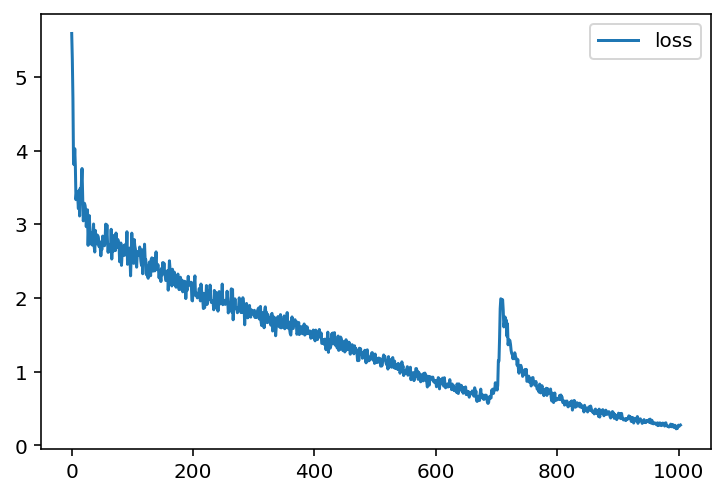

In [ ]:
MAX_LENGTH = max(map(len, string_notations))

for i in range(1000):
    batch_ix = to_matrix(sample(list(string_notations), 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Iteration passed:", i)
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return [tokens[ix] for ix in x_sequence.data.numpy()[0]]

In [ ]:
print(generate_sample(char_rnn))

[' ', 'B-2', 'F4', 'G2', '0.5', 'F4', 'B-2', ' ', 'B-1', 'F5', '0.4', '0.3', 'C5', '9.2', '5.9', '0.4', '0.3', 'F3', '9.0.2', '10', 'B-1', '0.4', 'E-3', '2.5.9', 'E-4', 'D6', 'F5', '9.2.3', 'D6', '2', 'D3', '10.2', 'A3', 'D5', 'E5', 'B3', 'D2', 'F3', 'A5', 'A2', '2.5', 'F3', 'E3', 'G3', 'D3', 'F3', 'D3', 'G3', 'D3', 'F3', 'A2', '2.5', 'F3', 'A2', '7.11', 'D3', 'D3', '9.0', '2.5', 'A2', '4.7', 'B3', '0.4', 'B3', 'E3', '10.2', 'G3', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'C4', 'A1', 'A3', 'F3', '4', 'B-2', 'B-3', 'C4', 'C4', 'A1', 'F3', 'B3', 'D4', 'B3', 'C5', 'G2', '11.1.6', 'G5', '0.2.7', '9.0.2.5', 'G3', 'D5', 'C4', '4.7', 'G3', 'C5', 'D4', 'E4', 'C4', 'G#4', 'D4', 'G3', 'C4', 'C3', 'F3', 'E6', 'G3', 'D3', 'G3', 'A3', 'D4', '2.7', 'D3', 'F5', 'B-3', 'B-4', 'G3', 'C5', 'F3', 'G3', 'E6', 'G3', 'G5', 'E4', '7.11', 'G3', 'B5', 'C6', 'D6', 'G3', 'G5', 'C6', 'D5', 'G3', 'F5', 'D3', 'C3', 'A3', '0.4', 'C5', 'A5', 'G5', '0.4', 'G3', 'F3', 'G2', '5.9', '2.5', 'D6', 'C3', 'C6', 'G2', 'G2', 'D4', '

In [ ]:
for _ in range(10):
    print(len(generate_sample(char_rnn)))